### Исследовательский Анализ Данных

#### План работы:

Загрузим все таблицы из папки и сохраним в соответствующие переменные и исследуем данные в загруженных таблицах.

Проверим на дубликаты и пустые значения, изменим при необходимости типы данных.

Найдем и удалим партии у которых температура измерялась только один раз - они бесполезны для обучения.

Для итоговой таблицы вычислим:

продолжительность нагрева стали,
суммарное время работы электродов,
суммарную произведенную работу,
количество включений электродов,
среднюю взвешенную мощность,
среднее взвешенное отношение мощностей.

Объединеним данные в одну таблицу по "key"

Выделяем признаки и разбиваем выборку  со смешиванием данных.

Выбор моделей, использование и обучение регрессионных моделей
(LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor).

Сравним полученные результаты наших моделей и выделим лучшую с помощью метрики MAE (Mean Absolute Error, Средняя Абсолютная Ошибка) — мера схожести предсказаний и правильных значений.

Общий вывод

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
from time import time
from IPython.display import display
warnings.filterwarnings('ignore')

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
class DataScience:

    def sns_draw(self, data, parametr, bins=30):
        fig = plt.figure(figsize=(20, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_right = fig.add_subplot(grid[:-1, -1])  
        sns.distplot(data[parametr], ax=ax_main)
        sns.boxplot(data[parametr], ax=ax_right)
        ax_right.grid(axis='y')
        ax_main.set(title='График '+parametr)
        ax_main.axvline(np.mean(data[parametr]),color='g', linestyle='--', label='Среднее')
        ax_main.axvline(np.median(data[parametr]),color='g', linestyle='-', label='Медиана')
        ax_main.legend()
        fig.show()
    
    def dataset_info(self,data):
        data.info()
        display(data.head(4))
        display(data.describe())
        print('Количество дубликатов:', data.duplicated().sum())
    

            
ds = DataScience()       

Загрузим данные и посмотрим на первые четыре строки.

In [4]:
ds.dataset_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов: 0


In [5]:
ds.dataset_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0


In [6]:
ds.dataset_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0


In [7]:
ds.dataset_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0


In [8]:
ds.dataset_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов: 0


In [9]:
ds.dataset_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0


In [10]:
ds.dataset_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов: 0


Изменим тип данных на datetime

In [11]:
for df in [data_temp, data_arc, data_wire_time, data_bulk_time]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_datetime(df[col])

Количество партий: 3216
Мода:  4


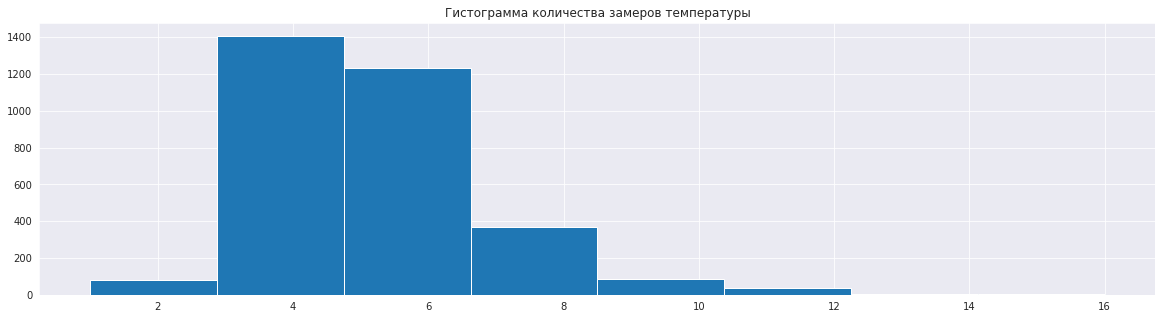

In [12]:
print('Количество партий:', data_temp['key'].nunique())
data_temp['key'].value_counts().hist(bins=8, figsize=(20,5))
mode = st.mode(data_arc['key'].value_counts())
print('Мода: ',mode[0][0])
plt.title('Гистограмма количества замеров температуры')
plt.show()

Количество замеров для отдельной партии от 1 до 16, чаще всего 3-7 замера.

In [13]:
print(f'Пропусков в столбце Температура: {data_temp["Температура"].isna().sum()}')
data_temp[data_temp['Температура'].isna()]

Пропусков в столбце Температура: 2901


,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Пропущенные значения после 2500й партии - отсутствует финальное значение температуры для отдельной партии. Это значение является целевым признаком, избавимся от партий с отсутствующими данными.



In [14]:
data_temp.query('Температура != "NaN" and key >= 2500').head()

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12271,2501,2019-08-06 03:44:42,1587.0
12276,2502,2019-08-06 04:45:26,1583.0
12283,2503,2019-08-06 05:32:06,1603.0
12287,2504,2019-08-06 06:35:39,1583.0


In [15]:
null_parties = data_temp[data_temp['Температура'].isna()]['key'].unique()
data_temp = data_temp.query('key not in @null_parties')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12267 entries, 0 to 12266
Data columns (total 3 columns):
key             12267 non-null int64
Время замера    12267 non-null datetime64[ns]
Температура     12267 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


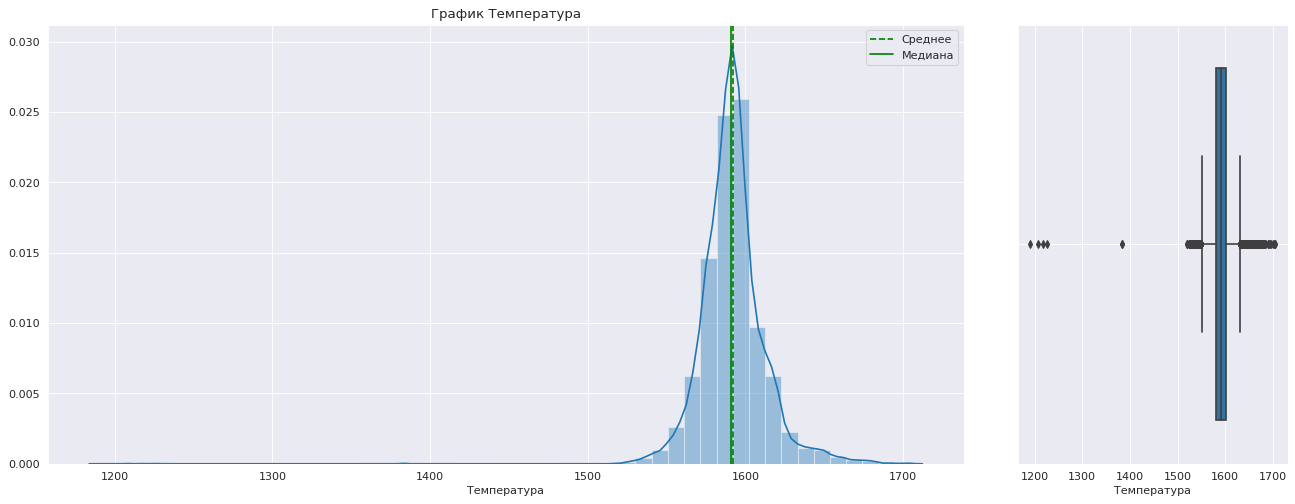

In [16]:
ds.sns_draw(data_temp, 'Температура')

У значений температуры нормальное распределение, большинство значений лежит на отрезке от 1550 до 1650 градусов.На диаграмме размахе видим выбросы на промежутке от 1200 до 1400 градусов - избавимся от них.

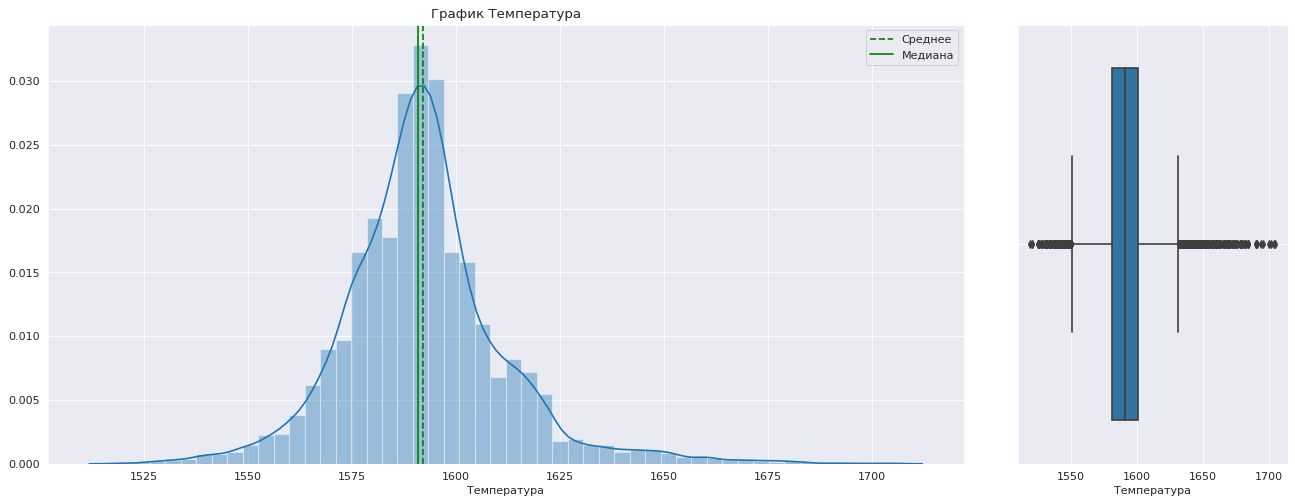

In [17]:
data_temp = data_temp.query('Температура > 1500')
ds.sns_draw(data_temp, 'Температура')

In [18]:
gp = data_temp.sort_values('Время замера').groupby('key')[['Температура','Время замера']]
data_all = (gp.first().join(gp.last(), rsuffix='_'))
data_all.columns = ['temp_0', 'temp_0_time', 'temp_final', 'temp_final_time']

data_all.head()
print('Размер выборки:', data_all.shape[0])

Размер выборки: 2477


Найдем и удалим партии, у которых температура измерялась только один раз - они бесполезны для обучения.

In [19]:
data_all.query('temp_0_time == temp_final_time')

,temp_0,temp_0_time,temp_final,temp_final_time
key,,,,
195,1583.0,2019-05-10 14:10:23,1583.0,2019-05-10 14:10:23
279,1603.0,2019-05-13 23:07:28,1603.0,2019-05-13 23:07:28


In [20]:
data_all = data_all.query('temp_0_time != temp_final_time')
print('Размер выборки:', data_all.shape[0])

Размер выборки: 2475


Для итоговой таблицы вычислим:

продолжительность нагрева стали

суммарное время работы электродов

суммарную произведенную работу

количество включений электродов

среднюю взвешенную мощность

среднее взвешенное отношение мощностей

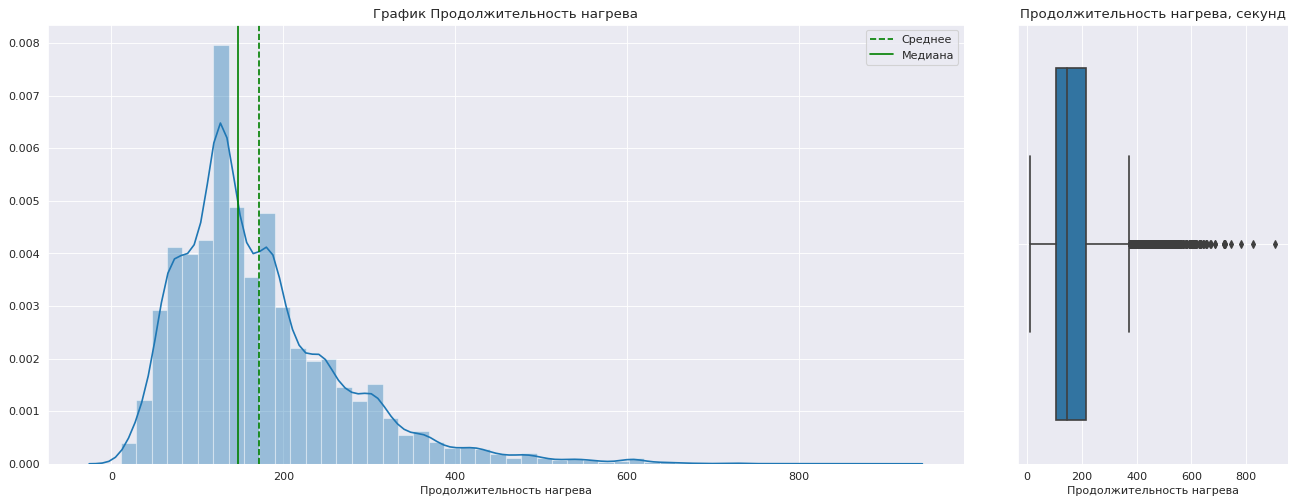

In [21]:
data_arc['Продолжительность нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
ds.sns_draw(data_arc, 'Продолжительность нагрева')
plt.title('Продолжительность нагрева, секунд')
plt.show()

In [22]:
data_arc['Мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
data_arc['Работа'] = data_arc['Активная мощность'] * data_arc['Продолжительность нагрева']
data_arc['Отношение мощностей'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']
data_arc.head(4)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева,Мощность,Работа,Отношение мощностей
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,222.541395,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,149.037310,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,128.030509,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,605.667332,1.561504


In [23]:
print('Размер выборки:', data_arc.shape[0])

Размер выборки: 14876


In [24]:
data_arc['p_t'] = data_arc['Отношение мощностей'] * data_arc['Продолжительность нагрева']

data_all[['heating_count',  
          'heating_duration', 
          'total_work']] = data_arc.pivot_table(index='key', aggfunc={'Начало нагрева дугой': 'count',
                                                                'Продолжительность нагрева':'sum',
                                                                'Работа': 'sum',
                                                         })
data_all['power_mean'] = data_all['total_work'] / data_all['heating_duration']
data_all['power_ratio_mean'] = data_arc.groupby('key')['p_t'].sum() / data_all['heating_duration']
data_all.head(3)

,temp_0,temp_0_time,temp_final,temp_final_time,heating_count,heating_duration,total_work,power_mean,power_ratio_mean
key,,,,,,,,,
1,1571.0,2019-05-03 11:16:18,1613.0,2019-05-03 11:30:39,5,1098,1207.804249,1.100004,1.534047
2,1581.0,2019-05-03 11:37:27,1602.0,2019-05-03 11:59:12,4,811,733.816470,0.904829,1.530791
3,1596.0,2019-05-03 12:13:17,1599.0,2019-05-03 12:34:57,5,655,443.583327,0.677226,1.579815


Циклы нагрева, которые произошли после финального финального замера температуры необходимо удалить из таблицы.

In [25]:
for key in data_all.index:
    data_arc.loc[data_arc['key'] == key, 'temp_final_time'] = data_all.loc[key, 'temp_final_time']
    
data_arc = data_arc.loc[data_arc['Начало нагрева дугой'] < data_arc['temp_final_time']]
print('Записей:', data_arc.shape[0])

Записей: 11315


In [26]:
data_arc['p_t'] = data_arc['Отношение мощностей'] * data_arc['Продолжительность нагрева'] 

data_all[['heating_count',  
          'heating_duration', 
          'total_work']] = data_arc.pivot_table(index='key', aggfunc={'Начало нагрева дугой': 'count',
                                                                'Продолжительность нагрева':'sum',
                                                                'Работа': 'sum',
                                                         })
data_all['power_mean'] = data_all['total_work'] / data_all['heating_duration']
data_all['power_ratio_mean'] = data_arc.groupby('key')['p_t'].sum() / data_all['heating_duration']
data_all.head(3)

,temp_0,temp_0_time,temp_final,temp_final_time,heating_count,heating_duration,total_work,power_mean,power_ratio_mean
key,,,,,,,,,
1,1571.0,2019-05-03 11:16:18,1613.0,2019-05-03 11:30:39,5,1098,1207.804249,1.100004,1.534047
2,1581.0,2019-05-03 11:37:27,1602.0,2019-05-03 11:59:12,4,811,733.816470,0.904829,1.530791
3,1596.0,2019-05-03 12:13:17,1599.0,2019-05-03 12:34:57,5,655,443.583327,0.677226,1.579815


Добавим информацию о продувке газом.

In [27]:
data_all['gas'] = data_gas.set_index('key')

In [28]:
data_bulk.set_index('key', inplace=True)          
data_bulk_time.set_index('key', inplace=True)

Удалим информацию, добавленную после финального замера температуры:

In [29]:
data_bulk_time['final_time'] = data_all['temp_final_time'] 
for column in data_bulk_time.columns[:-1]:
    data_bulk_time[column] = data_bulk_time[column] <= data_bulk_time['final_time']
    
data_bulk = data_bulk.where(data_bulk_time, 0)             
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [30]:
value_count = (data_bulk != 0).sum()
value_count

Bulk 1      199
Bulk 2       13
Bulk 3      963
Bulk 4      810
Bulk 5       53
Bulk 6      442
Bulk 7       14
Bulk 8        1
Bulk 9       13
Bulk 10     142
Bulk 11     129
Bulk 12    1882
Bulk 13      14
Bulk 14    2137
Bulk 15    1713
dtype: int64

In [31]:
data_bulk = data_bulk[value_count[value_count > 100].index]

In [32]:
data_all = data_all.join(data_bulk)

In [33]:
data_wire.set_index('key', inplace=True)
data_wire_time.set_index('key', inplace=True)

In [34]:
data_wire_time['final_time'] = data_all['temp_final_time'] 
for column in data_wire_time.columns[:-1]:
    data_wire_time[column] = data_wire_time[column] <= data_wire_time['final_time']
data_wire = data_wire.where(data_wire_time, 0)

In [35]:
value_count = (data_wire != 0).sum()
data_wire = data_wire[value_count[value_count > 100].index]

In [36]:
data_all = data_all.join(data_wire)

Проверим данные на коллинеарность.

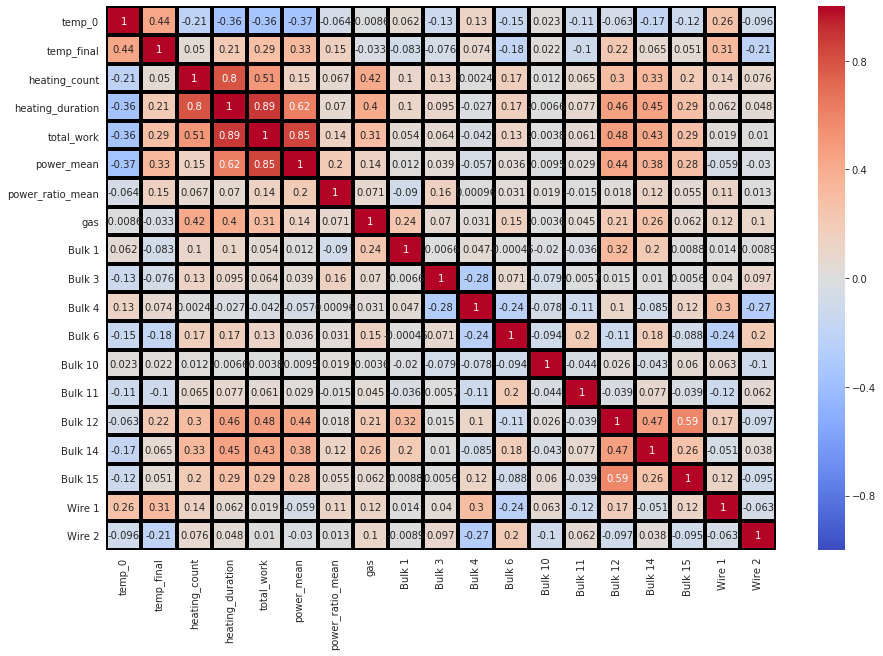

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(data_all.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

### Подготовка признаков

In [38]:
data_all = data_all.drop(columns=['temp_0_time', 'temp_final_time']).fillna(0) 

display(data_all.head(5), data_all.shape)

,temp_0,temp_final,heating_count,heating_duration,total_work,power_mean,power_ratio_mean,gas,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
key,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,1098,1207.804249,1.100004,1.534047,29.749986,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000
2,1581.0,1602.0,4,811,733.816470,0.904829,1.530791,12.555561,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000
3,1596.0,1599.0,5,655,443.583327,0.677226,1.579815,28.554793,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000
4,1601.0,1625.0,4,741,670.663327,0.905079,1.561254,18.841219,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000
5,1576.0,1602.0,4,869,997.496095,1.147867,1.488775,5.413692,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456


(2475, 19)

Для обучения доступна информация о 2475 циклах, каждый из которых содержит 19 признаков.
Выделим целевой признак в переменную target, а остальные - в переменную features:

In [39]:
features = data_all.drop(columns = ['temp_final'])
target = data_all['temp_final']

In [40]:
tr_and_val_feats, test_feats, tr_and_val_target, test_target = train_test_split(features, target,
                                                                                train_size = 0.8,   
                                                                                random_state = 12345)
train_feats, valid_feats, train_target, valid_target = train_test_split(tr_and_val_feats, 
                                                                        tr_and_val_target,
                                                                        train_size = 0.75,         
                                                                        random_state = 12345)

print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Валидационная \t {valid_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 1485
Валидационная 	 495
Тестовая 	 495


### Обучение моделей

#### LinearRegression

In [41]:
def model_quick_test(model, name):
    '''Обучение модели на train и нахождение MAE на valid'''
    t_0 = time()
    model.fit(train_feats, train_target)
    t_fit = time() - t_0
    train_pred = model.predict(train_feats)
    train_mae = mean_absolute_error(train_pred, train_target)
    valid_pred = model.predict(valid_feats)
    valid_mae = mean_absolute_error(valid_pred, valid_target)
    print(f'Модель: {name}' +
          f'\nMAE на тренировочных данных: {round(train_mae, 4)}' +
          f'\nMAE на валидационных данных: {round(valid_mae, 4)}' +
          f'\nВремя обучения: {round(t_fit, 4)} с.')

model_quick_test(LinearRegression(), 'Линейная регрессия')

Модель: Линейная регрессия
MAE на тренировочных данных: 7.3807
MAE на валидационных данных: 7.929
Время обучения: 0.004 с.


#### RandomForestRegressor

In [42]:
model_quick_test(RandomForestRegressor(100), 'Случайный лес')

Модель: Случайный лес
MAE на тренировочных данных: 2.3555
MAE на валидационных данных: 6.4671
Время обучения: 1.5178 с.


Используем GridSearchCV для улучшения результатов модели

In [43]:
SKIP_GRID_SEARCH = True                                  

if SKIP_GRID_SEARCH:                                        
    parameters = {'n_estimators': [100], 'max_depth': [20]}
else:                                                       
    parameters = {'n_estimators': range(50, 201, 25),
                  'max_depth': range(10, 31, 5)}

grid = GridSearchCV(estimator = RandomForestRegressor(random_state = 12345),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    cv = 5,
                    verbose = False,
                    n_jobs=-1)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для RandomForestRegressor являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

Оптимальными параметрами для RandomForestRegressor являются {'max_depth': 20, 'n_estimators': 100}
Средняя МАЕ: 6.1828


#### LGBMRegressor

In [44]:
model_quick_test(LGBMRegressor(random_state=12345), 'Градиентный бустинг')

Модель: Градиентный бустинг
MAE на тренировочных данных: 2.5334
MAE на валидационных данных: 6.4293
Время обучения: 3.4146 с.


Используем GridSearchCV для улучшения результатов модели

In [45]:
SKIP_GRID_SEARCH = True  

if SKIP_GRID_SEARCH: 
    parameters = {'learning_rate': [0.1], 'max_depth': [-1], 'n_estimators': [60]}
else:
    parameters = {'max_depth': [-1, 3, 5, 8],
                  'learning_rate': [0.01, 0.05, 0.1, 0.5],
                  'n_estimators': range(40, 101, 20)
                  }

grid = GridSearchCV(estimator = LGBMRegressor(random_state=12345),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    verbose = False)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для LGBMRegressor являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

Оптимальными параметрами для LGBMRegressor являются {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 60}
Средняя МАЕ: 6.2775


In [46]:
model_quick_test(CatBoostRegressor(random_state=12345), 'CatBoostRegressor')

0:	learn: 15.5567465	total: 49.5ms	remaining: 49.5s
1:	learn: 15.3402235	total: 53.8ms	remaining: 26.9s
2:	learn: 15.1091998	total: 58.9ms	remaining: 19.6s
3:	learn: 14.8816909	total: 66.4ms	remaining: 16.5s
4:	learn: 14.6821746	total: 73.4ms	remaining: 14.6s
5:	learn: 14.4907658	total: 148ms	remaining: 24.5s
6:	learn: 14.2762809	total: 155ms	remaining: 22s
7:	learn: 14.0743484	total: 160ms	remaining: 19.8s
8:	learn: 13.8902180	total: 165ms	remaining: 18.2s
9:	learn: 13.7203659	total: 169ms	remaining: 16.7s
10:	learn: 13.5596996	total: 252ms	remaining: 22.7s
11:	learn: 13.3993784	total: 258ms	remaining: 21.2s
12:	learn: 13.2457979	total: 262ms	remaining: 19.9s
13:	learn: 13.0786305	total: 268ms	remaining: 18.9s
14:	learn: 12.9300018	total: 275ms	remaining: 18.1s
15:	learn: 12.7981641	total: 345ms	remaining: 21.2s
16:	learn: 12.6662909	total: 349ms	remaining: 20.2s
17:	learn: 12.5268482	total: 353ms	remaining: 19.3s
18:	learn: 12.3898709	total: 365ms	remaining: 18.9s
19:	learn: 12.25102

In [47]:
SKIP_GRID_SEARCH = True  

if SKIP_GRID_SEARCH: 
    parameters = {'depth': [4], 'l2_leaf_reg': [1], 'learning_rate': [0.03]}
else:
    parameters = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
    
grid = GridSearchCV(estimator = CatBoostRegressor(random_state=12345),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    verbose = False)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для CatBoostRegressor являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

0:	learn: 16.1540194	total: 4.58ms	remaining: 4.58s
1:	learn: 15.8931895	total: 9.71ms	remaining: 4.84s
2:	learn: 15.6682693	total: 14.6ms	remaining: 4.84s
3:	learn: 15.4337545	total: 17.6ms	remaining: 4.39s
4:	learn: 15.2056116	total: 19ms	remaining: 3.78s
5:	learn: 14.9829763	total: 20ms	remaining: 3.31s
6:	learn: 14.7709854	total: 21ms	remaining: 2.97s
7:	learn: 14.5719174	total: 21.9ms	remaining: 2.72s
8:	learn: 14.3711339	total: 98.4ms	remaining: 10.8s
9:	learn: 14.1957645	total: 102ms	remaining: 10.1s
10:	learn: 14.0207080	total: 107ms	remaining: 9.58s
11:	learn: 13.8366393	total: 112ms	remaining: 9.23s
12:	learn: 13.6501517	total: 115ms	remaining: 8.72s
13:	learn: 13.5026260	total: 117ms	remaining: 8.27s
14:	learn: 13.3465996	total: 193ms	remaining: 12.6s
15:	learn: 13.1628517	total: 200ms	remaining: 12.3s
16:	learn: 13.0174567	total: 206ms	remaining: 11.9s
17:	learn: 12.8958238	total: 208ms	remaining: 11.3s
18:	learn: 12.7790049	total: 210ms	remaining: 10.8s
19:	learn: 12.64788

In [48]:
model_quick_test(XGBRegressor(random_state=12345), XGBRegressor)

[06:53:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Модель: <class 'xgboost.sklearn.XGBRegressor'>
MAE на тренировочных данных: 4.926
MAE на валидационных данных: 6.4511
Время обучения: 0.1812 с.


In [49]:
SKIP_GRID_SEARCH = True  

if SKIP_GRID_SEARCH: 
    parameters = {'max_depth': [5], 'min_child_weight': [0.0]}
else:
    parameters = {'min_child_weight': np.arange(0, 1, 0.1),
        'max_depth': np.arange(0, 6, 1)}
    
grid = GridSearchCV(estimator = XGBRegressor(random_state=12345),
                    param_grid = parameters,
                    scoring = 'neg_mean_absolute_error',
                    verbose = False)

grid.fit(tr_and_val_feats, tr_and_val_target)

print(f'Оптимальными параметрами для XGBRegressor являются {grid.best_params_}' +
      f'\nСредняя МАЕ: {-round(grid.best_score_, 4)}')

[06:53:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Оптимальными параметрами для XGBRegressor являются {'max_depth': 5, 'min_child_weight': 0.0}
Средняя МАЕ: 6.2392


In [50]:
t_0 = time()
model = LinearRegression()
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

Результаты:
 MAE на тестовых данных: 7.5523,
 время обучения: 0.0044 с.


In [51]:
t_0 = time()
model = RandomForestRegressor(n_estimators = 100, max_depth = 20, random_state = 12345)
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

Результаты:
 MAE на тестовых данных: 6.279,
 время обучения: 2.1298 с.


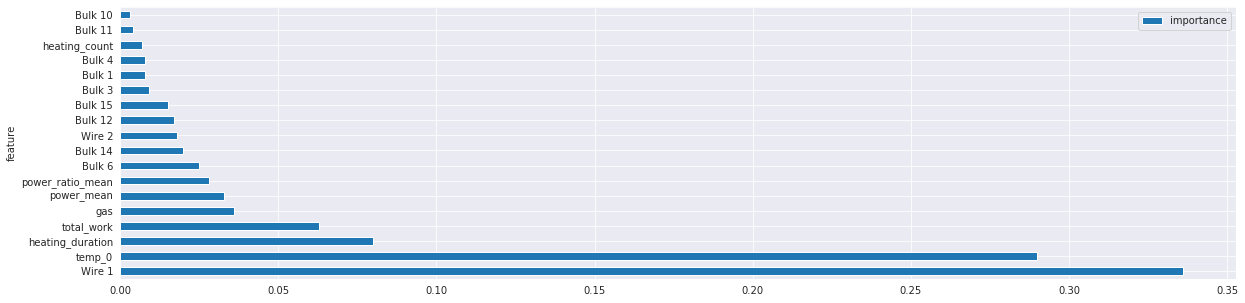

In [52]:
importances = pd.DataFrame({'feature':test_feats.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.barh(figsize=(20, 5))

In [53]:
t_0 = time()
model = LGBMRegressor(learning_rate = 0.1, max_depth = -1, n_estimators = 60)
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

Результаты:
 MAE на тестовых данных: 6.4658,
 время обучения: 0.1992 с.


In [54]:
t_0 = time()
model = CatBoostRegressor(depth = 4, l2_leaf_reg = 1, learning_rate = 0.03)
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

0:	learn: 15.8695028	total: 1.47ms	remaining: 1.47s
1:	learn: 15.6239063	total: 3.16ms	remaining: 1.58s
2:	learn: 15.3971228	total: 4.93ms	remaining: 1.64s
3:	learn: 15.1574220	total: 7.94ms	remaining: 1.98s
4:	learn: 14.9284668	total: 9.39ms	remaining: 1.87s
5:	learn: 14.7309323	total: 11.3ms	remaining: 1.88s
6:	learn: 14.5401522	total: 18.2ms	remaining: 2.58s
7:	learn: 14.3383383	total: 70.9ms	remaining: 8.79s
8:	learn: 14.1588392	total: 78.3ms	remaining: 8.62s
9:	learn: 13.9690084	total: 84.2ms	remaining: 8.34s
10:	learn: 13.7829293	total: 88.1ms	remaining: 7.92s
11:	learn: 13.6112633	total: 90.5ms	remaining: 7.45s
12:	learn: 13.4314311	total: 92ms	remaining: 6.99s
13:	learn: 13.2731138	total: 93.7ms	remaining: 6.6s
14:	learn: 13.1124680	total: 100ms	remaining: 6.59s
15:	learn: 12.9583279	total: 171ms	remaining: 10.5s
16:	learn: 12.8347554	total: 178ms	remaining: 10.3s
17:	learn: 12.7124968	total: 183ms	remaining: 9.97s
18:	learn: 12.5831668	total: 186ms	remaining: 9.58s
19:	learn: 

Для понимания работы модели посмотрим как она ранжировала признаки по важности.

                  importance
feature                     
Wire 1                30.865
temp_0                26.885
total_work            10.821
heating_duration       5.437
power_mean             3.993
power_ratio_mean       2.963
Bulk 6                 2.674
Bulk 1                 2.577
gas                    2.527
Bulk 15                2.426
Bulk 14                2.266
Wire 2                 1.852
Bulk 12                1.286
Bulk 4                 1.045
heating_count          0.906
Bulk 3                 0.747
Bulk 11                0.548
Bulk 10                0.181


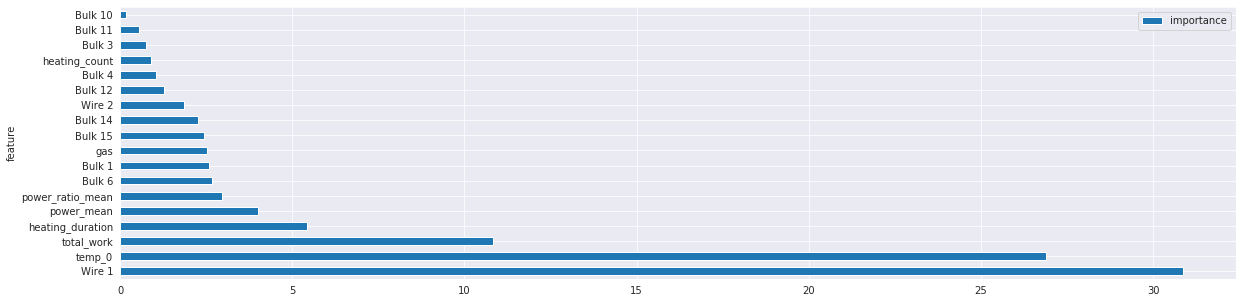

In [55]:
importances = pd.DataFrame({'feature':test_feats.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)
importances.plot.barh(figsize=(20, 5))

In [56]:
t_0 = time()
model = XGBRegressor(max_depth = 5, min_child_weight = 0.0)
model.fit(tr_and_val_feats, tr_and_val_target)
t_fit = time() - t_0
test_pred = model.predict(test_feats)
test_rmse = mean_absolute_error(test_pred, test_target)
print('Результаты:\n',
     f'MAE на тестовых данных: {round(test_rmse, 4)},\n',
     f'время обучения: {round(t_fit, 4)} с.')

[06:53:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Результаты:
 MAE на тестовых данных: 6.3437,
 время обучения: 0.3627 с.


### Общий вывод

Первым этапом проекта являлось составление плана работ. Все намеченные этапы были выполнены. Большое количество времени уделил анализу таблиц, поскольку в них содержалось много пропусков и выбросов, которые могли отрицательно повлиять на результат работы модели. Опираясь на исходные данные были добавлены новые признаки.
Использование и обучение регрессионных моделей (LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor).
Лучший результат MAE 6.23 на тестовой выборке CatBoostRegressor и  6.27 на тестовой выборке RandomForestRegressor.